In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Applay Graphcut

In [2]:
# Read the original imageAedes_vexans
original_image = cv2.imread("images/13976_front.jpg")

# Define boundary rectangle containing the foreground object
height, width, _ = original_image.shape
left_margin_proportion = 0.1
right_margin_proportion = 0.1
up_margin_proportion = 0.1
down_margin_proportion = 0.1

boundary_rectangle = (
    int(width * left_margin_proportion),
    int(height * up_margin_proportion),
    int(width * (1 - right_margin_proportion)),
    int(height * (1 - down_margin_proportion)),
)

print(boundary_rectangle )
# Set the seed for reproducibility purposes
cv2.setRNGSeed(0)

# Initialize GrabCut mask image, that will store the segmentation results
mask = np.zeros((height, width), np.uint8)

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

number_of_iterations = 5

cv2.grabCut(
    img=original_image,
    mask=mask,
    rect=boundary_rectangle,
    bgdModel=background_model,
    fgdModel=foreground_model,
    iterCount=number_of_iterations,
    mode=cv2.GC_INIT_WITH_RECT,
)


grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
    "uint8"
)
segmented_image = original_image.copy() * grabcut_mask[:, :, np.newaxis]

(87, 86, 785, 781)


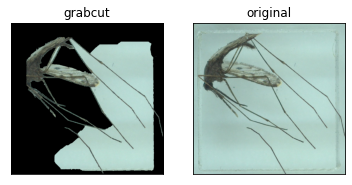

In [3]:
plt.subplot(121)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title("grabcut")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("original")
plt.xticks([])
plt.yticks([])

plt.show()

## Apply GraphCut with a combined initialization (Binarize input image)

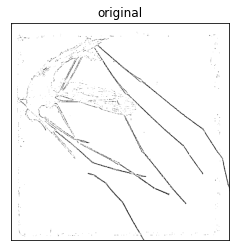

In [4]:
# Binarize input image
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)


binarized_image = cv2.adaptiveThreshold(
    gray_image,
    maxValue=1,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=5,
    C=7,
)
plt.imshow(binarized_image*255, cmap='gray')
plt.title("original")
plt.xticks([])
plt.yticks([])
plt.show()

# Initialize the mask with known information
mask = np.zeros((height, width), np.uint8)
mask[:] = cv2.GC_PR_BGD
mask[binarized_image == 0] = cv2.GC_FGD

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

cv2.grabCut(
    original_image,
    mask,
    boundary_rectangle,
    background_model,
    foreground_model,
    number_of_iterations,
    cv2.GC_INIT_WITH_MASK,
)

grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
    "uint8"
)
segmented_image = original_image.copy() * grabcut_mask[:, :, np.newaxis]

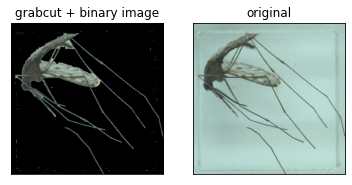

In [5]:
plt.subplot(121)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title("grabcut + binary image")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("original")
plt.xticks([])
plt.yticks([])
plt.show()

## GMM + Graphcut

In [6]:
import cv2 
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
from PIL import Image
# Read the original imageAedes_vexans
original_image = cv2.imread("images/13976_front.jpg")
# Define boundary rectangle containing the foreground object
height, width, _ = original_image.shape
left_margin_proportion = 0.1
right_margin_proportion = 0.1
up_margin_proportion = 0.1
down_margin_proportion = 0.1

boundary_rectangle = (
    int(width * left_margin_proportion),
    int(height * up_margin_proportion),
    int(width * (1 - right_margin_proportion)),
    int(height * (1 - down_margin_proportion)),
)
number_of_iterations = 5
img=original_image
print(np.array(img).shape)
img2 = img.reshape((-1, 3))
print(np.array(img2).shape)
gmm_model = GMM(n_components=2 , covariance_type='tied').fit(img2)
gmm_label = gmm_model.predict(img2)
segmented_img = gmm_label.reshape(img.shape[0],img.shape[1])

# x= Image.fromarray(np.uint8(segmented_img*255),'L')
# x.show()

(868, 873, 3)
(757764, 3)


In [7]:
# Binarize input image
binarized_image = segmented_img
# Initialize the mask with known information
mask = np.zeros((height, width), np.uint8)
mask[:] = cv2.GC_PR_BGD
mask[binarized_image == 1] = cv2.GC_FGD

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

cv2.grabCut(
    img,
    mask,
    boundary_rectangle,
    background_model,
    foreground_model,
    number_of_iterations,
    cv2.GC_INIT_WITH_MASK,
)

grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
    "uint8"
)
segmented_image = img.copy() * grabcut_mask[:, :, np.newaxis]
segmented_image = cv2.fastNlMeansDenoisingColored(segmented_image,None,20,10,7,21)

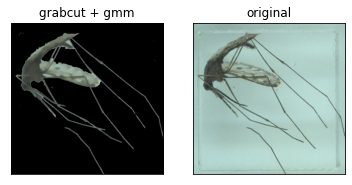

In [8]:
plt.subplot(121)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
cv2.imwrite("images/seg.jpg", cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))  
plt.title("grabcut + gmm")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("original")
plt.xticks([])
plt.yticks([])




plt.show()

648


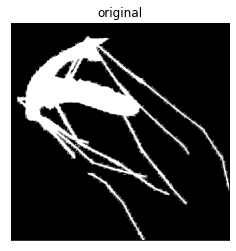

In [9]:
def removeSmallComponents(image, threshold):
    #find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, -2]
#     print(sizes)
    nb_components = nb_components - 1
    print(nb_components)
    img2 = np.zeros((output.shape),dtype = np.uint8)
    #for every component in the image, you keep it only if it's above threshold
    for i in range(0, nb_components):
        if sizes[i] >= threshold:
            img2[output == i + 1] = 255
    return img2

image = cv2.imread('images/seg.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
thresh = cv2.threshold(gray, 100, 255,cv2.THRESH_BINARY)[1]
img = removeSmallComponents(gray, 100)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("original")
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
masked = cv2.bitwise_and(image, image, mask=img)
# cv2.imshow("Mask Applied to Image", masked)
# cv2.waitKey(0)

In [11]:
tmp = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
_,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
b, g, r = cv2.split(masked)
rgba = [b,g,r, alpha]
dst = cv2.merge(rgba,4)
cv2.imwrite("images/obj.jpg", cv2.resize(dst,(250,250)))

True

In [12]:
black_image = np.zeros((500, 500, 3), dtype = "uint8")
cv2.imwrite('images/black_imag.jpg', black_image)


True

In [13]:
img1 = cv2.imread('images/black_imag.jpg')
overlay_img1 = np.ones(img1.shape,np.uint8)*255

img2 = cv2.imread('images/obj.jpg')
rows,cols,channels = img2.shape
overlay_img1[125:rows+125, 125:cols+125 ] = img2

img2gray = cv2.cvtColor(overlay_img1,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray,220,55,cv2.THRESH_BINARY_INV)
mask_inv = cv2.bitwise_not(mask)
temp1 = cv2.bitwise_and(img1,img1,mask = mask_inv)
temp2 = cv2.bitwise_and(overlay_img1,overlay_img1, mask = mask)

result = cv2.add(temp1,temp2)
# cv2.imshow("Result",result)
cv2.imwrite('images/output.jpg',result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True